TASK 2: MODEL BUILDING AND TRAINING

📁 1. LOADING PROCESSED DATA
--------------------------------------------------
Processed data directory: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\data\processed
Models directory: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models
✅ Data loaded successfully!
   X_train shape: (103316, 25)
   X_test shape: (25830, 25)
   Features: 25
   Training samples: 103,316
   Test samples: 25,830
   Training fraud rate: 9.50%
   Test fraud rate: 9.50%

📊 Feature Information:
   First 10 features: ['purchase_value', 'age', 'purchase_hour', 'purchase_dayofweek', 'purchase_month', 'is_weekend', 'is_night', 'time_since_signup_hours', 'time_since_signup_days', 'is_same_day_purchase']
   ... and 15 more features

📚 2. IMPORTING MACHINE LEARNING LIBRARIES
--------------------------------------------------
✅ XGBoost available
⚠️ LightGBM not available
✅ All required libraries imported

📈 3. DEFINING EVALUATION METRICS FOR IMBALANCED DATA
-------------

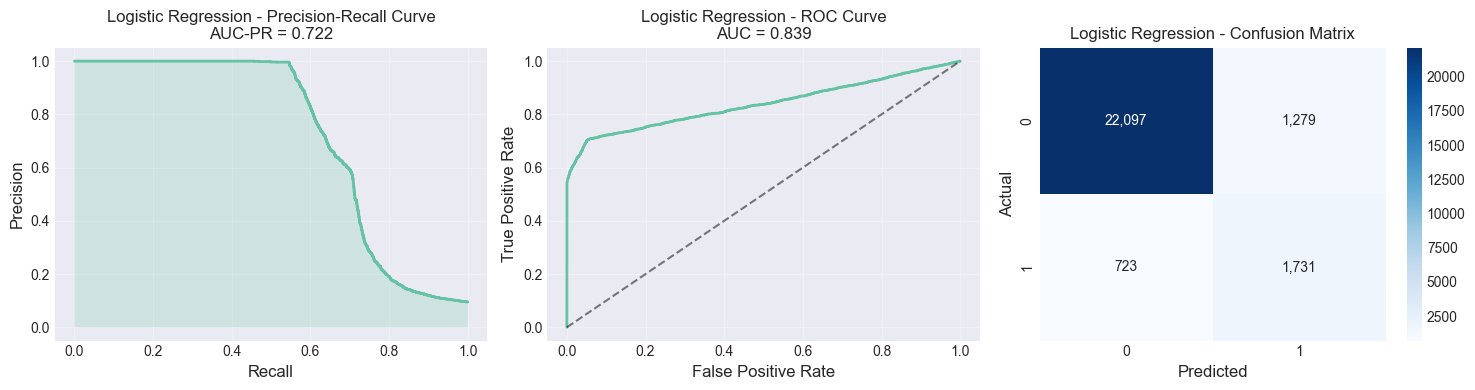


💾 Baseline model saved to: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models/logistic_regression.pkl

🌲 5. ENSEMBLE MODEL: RANDOM FOREST
--------------------------------------------------
Training Random Forest with hyperparameter tuning for fraud detection...
Training Random Forest...
✅ Random Forest trained successfully

📊 Evaluating Random Forest...

RANDOM FOREST - PERFORMANCE METRICS
AUC-PR:            0.7202  (Primary metric for imbalanced data)
ROC-AUC:           0.8373
F1-Score:          0.6591
Precision:         0.6537  (1 - False Positive Rate)
Recall:            0.6646    (True Positive Rate)
Accuracy:          0.9347
Inference Time:    524.02 ms

📊 CONFUSION MATRIX:
┌──────────────────────┐
│ TN: 22,512 │ FP:    864 │
├──────────────────────┤
│ FN:    823 │ TP:  1,631 │
└──────────────────────┘

💼 BUSINESS IMPACT ANALYSIS:
   Total Transactions:     25,830
   Actual Fraud:           2,454 (9.50%)
   Fraud Detected:         1,631 (66.5% of fraud)
   Fraud Missed:  

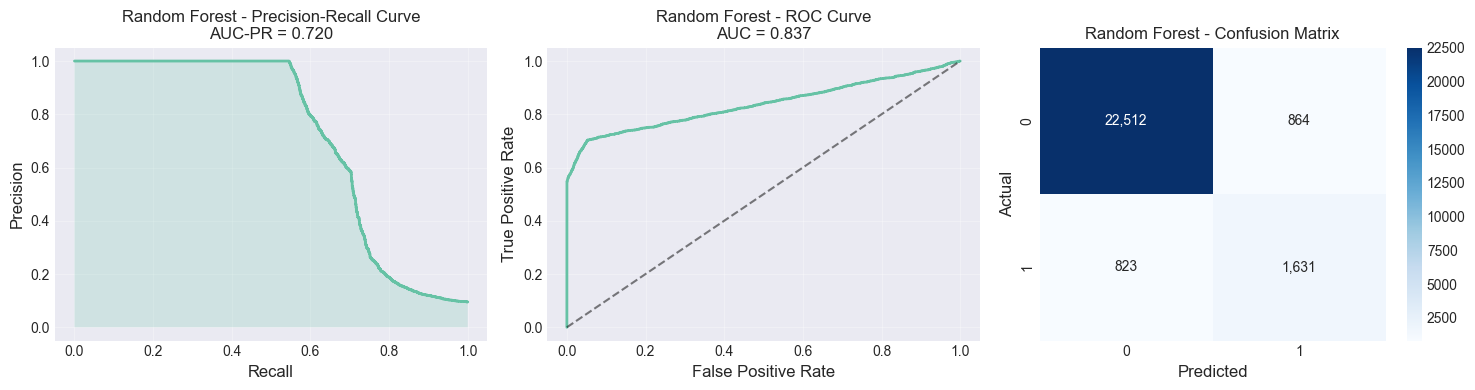


🔍 Random Forest Feature Importance (Top 15):


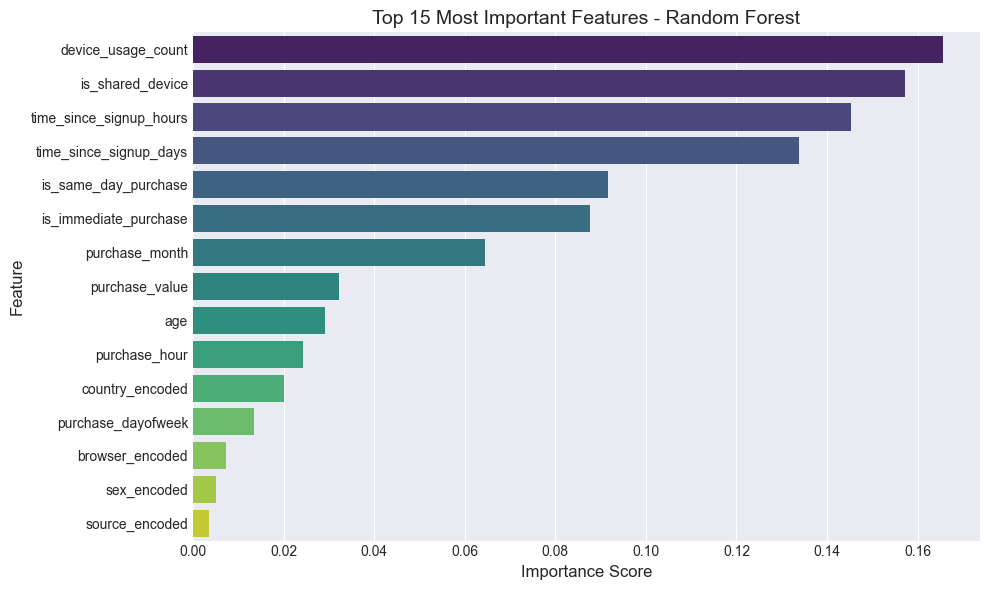

                Feature  Importance
     device_usage_count    0.165492
       is_shared_device    0.157173
time_since_signup_hours    0.145318
 time_since_signup_days    0.133739
   is_same_day_purchase    0.091532
  is_immediate_purchase    0.087720
         purchase_month    0.064407
         purchase_value    0.032284
                    age    0.029141
          purchase_hour    0.024327
        country_encoded    0.020086
     purchase_dayofweek    0.013419
        browser_encoded    0.007267
            sex_encoded    0.005018
         source_encoded    0.003442

💾 Random Forest model saved to: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models/random_forest.pkl

🚀 6. GRADIENT BOOSTING MODELS
--------------------------------------------------

🌳 Training XGBoost...
Scale pos weight for XGBoost: 9.53
✅ XGBoost trained successfully

📊 Evaluating XGBoost...

XGBOOST - PERFORMANCE METRICS
AUC-PR:            0.7202  (Primary metric for imbalanced data)
ROC-AUC:           0.83

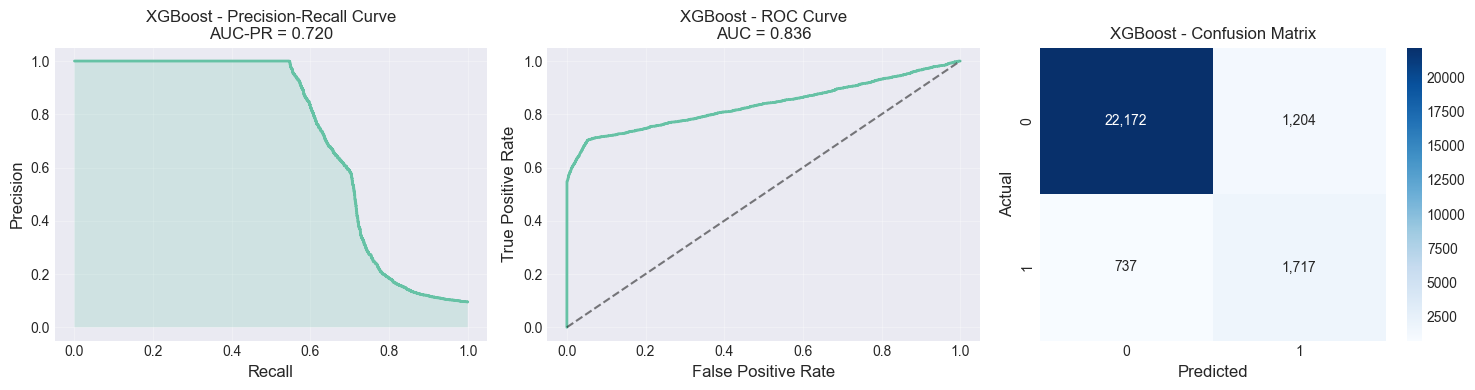

💾 XGBoost model saved to: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models/xgboost.pkl

🔄 7. CROSS-VALIDATION FOR RELIABLE ESTIMATION
--------------------------------------------------
Performing Stratified 5-Fold Cross-Validation on Random Forest...


In [ ]:
# ==================== TASK 2: MODEL BUILDING AND TRAINING ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

print("="*70)
print("TASK 2: MODEL BUILDING AND TRAINING")
print("="*70)

# ==================== 1. LOAD PROCESSED DATA ====================
print("\n📁 1. LOADING PROCESSED DATA")
print("-"*50)

import os
from pathlib import Path

# Define paths
BASE_DIR = Path.cwd()
PROCESSED_DIR = BASE_DIR.parent / "data" / "processed" if BASE_DIR.name == "notebooks" else BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR.parent / "models" if BASE_DIR.name == "notebooks" else BASE_DIR / "models"

# Create models directory if it doesn't exist
MODELS_DIR.mkdir(exist_ok=True)

print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Models directory: {MODELS_DIR}")

# Load processed data
try:
    X_train = pd.read_csv(PROCESSED_DIR / "X_train.csv")
    X_test = pd.read_csv(PROCESSED_DIR / "X_test.csv")
    y_train = pd.read_csv(PROCESSED_DIR / "y_train.csv")
    y_test = pd.read_csv(PROCESSED_DIR / "y_test.csv")
    
    # Convert to Series if needed
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0]
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]
    
    print("✅ Data loaded successfully!")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Training samples: {X_train.shape[0]:,}")
    print(f"   Test samples: {X_test.shape[0]:,}")
    print(f"   Training fraud rate: {y_train.mean():.2%}")
    print(f"   Test fraud rate: {y_test.mean():.2%}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please run Task 1 first to generate processed data")
    exit(1)

# Display feature information
print(f"\n📊 Feature Information:")
print(f"   First 10 features: {list(X_train.columns[:10])}")
if X_train.shape[1] > 10:
    print(f"   ... and {X_train.shape[1] - 10} more features")

# ==================== 2. IMPORT REQUIRED LIBRARIES ====================
print("\n📚 2. IMPORTING MACHINE LEARNING LIBRARIES")
print("-"*50)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, 
                            precision_recall_curve, average_precision_score,
                            roc_auc_score, roc_curve, f1_score, precision_score, 
                            recall_score, accuracy_score)
import joblib
import time

# Check for XGBoost availability
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    XGB_AVAILABLE = False
    print("⚠️ XGBoost not available, will use Random Forest only")

# Check for LightGBM availability
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
    print("✅ LightGBM available")
except ImportError:
    LGBM_AVAILABLE = False
    print("⚠️ LightGBM not available")

print("✅ All required libraries imported")

# ==================== 3. DEFINE EVALUATION FUNCTIONS ====================
print("\n📈 3. DEFINING EVALUATION METRICS FOR IMBALANCED DATA")
print("-"*50)

print("For fraud detection with imbalanced data, we prioritize:")
print("  ✅ AUC-PR (Precision-Recall AUC) - PRIMARY METRIC")
print("  ✅ F1-Score - Balance of precision and recall")
print("  ✅ Precision - Minimize false positives (customer experience)")
print("  ✅ Recall - Maximize true positives (fraud detection)")
print("  ✅ ROC-AUC - Overall discrimination ability")

def evaluate_model(model, X_test, y_test, model_name="Model", return_metrics=False):
    """
    Comprehensive evaluation for fraud detection models
    """
    start_time = time.time()
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'AUC-PR': average_precision_score(y_test, y_pred_proba),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'Accuracy': accuracy_score(y_test, y_pred)
    }
    
    end_time = time.time()
    metrics['Inference Time (ms)'] = (end_time - start_time) * 1000
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} - PERFORMANCE METRICS")
    print('='*60)
    print(f"AUC-PR:            {metrics['AUC-PR']:.4f}  (Primary metric for imbalanced data)")
    print(f"ROC-AUC:           {metrics['ROC-AUC']:.4f}")
    print(f"F1-Score:          {metrics['F1-Score']:.4f}")
    print(f"Precision:         {metrics['Precision']:.4f}  (1 - False Positive Rate)")
    print(f"Recall:            {metrics['Recall']:.4f}    (True Positive Rate)")
    print(f"Accuracy:          {metrics['Accuracy']:.4f}")
    print(f"Inference Time:    {metrics['Inference Time (ms)']:.2f} ms")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"┌──────────────────────┐")
    print(f"│ TN: {cm[0,0]:>6,} │ FP: {cm[0,1]:>6,} │")
    print(f"├──────────────────────┤")
    print(f"│ FN: {cm[1,0]:>6,} │ TP: {cm[1,1]:>6,} │")
    print(f"└──────────────────────┘")
    
    # Business impact metrics
    total_transactions = cm.sum()
    fraud_transactions = cm[1, :].sum()
    detected_fraud = cm[1, 1]
    missed_fraud = cm[1, 0]
    false_alarms = cm[0, 1]
    
    print(f"\n💼 BUSINESS IMPACT ANALYSIS:")
    print(f"   Total Transactions:     {total_transactions:,}")
    print(f"   Actual Fraud:           {fraud_transactions:,} ({fraud_transactions/total_transactions:.2%})")
    print(f"   Fraud Detected:         {detected_fraud:,} ({detected_fraud/fraud_transactions:.1%} of fraud)")
    print(f"   Fraud Missed:           {missed_fraud:,} ({missed_fraud/fraud_transactions:.1%} of fraud)")
    print(f"   False Alarms:           {false_alarms:,} ({false_alarms/total_transactions:.2%} of all transactions)")
    
    # Calculate financial impact (example)
    avg_transaction_value = 36.94  # From EDA in Task 1
    fraud_prevention_value = detected_fraud * avg_transaction_value
    customer_inconvenience_cost = false_alarms * 10  # $10 per false alarm (example)
    net_benefit = fraud_prevention_value - customer_inconvenience_cost
    
    print(f"\n💰 ESTIMATED FINANCIAL IMPACT (Example):")
    print(f"   Fraud Prevented:        ${fraud_prevention_value:,.2f}")
    print(f"   Customer Inconvenience: ${customer_inconvenience_cost:,.2f}")
    print(f"   Net Benefit:            ${net_benefit:,.2f}")
    
    if return_metrics:
        return metrics, y_pred, y_pred_proba, cm
    return metrics

def plot_model_performance(y_test, y_pred_proba, model_name, metrics):
    """
    Plot performance curves for a model
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[0].plot(recall, precision, linewidth=2)
    axes[0].fill_between(recall, precision, alpha=0.2)
    axes[0].set_xlabel('Recall', fontsize=12)
    axes[0].set_ylabel('Precision', fontsize=12)
    axes[0].set_title(f'{model_name} - Precision-Recall Curve\nAUC-PR = {metrics["AUC-PR"]:.3f}', fontsize=12)
    axes[0].grid(alpha=0.3)
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1].set_xlabel('False Positive Rate', fontsize=12)
    axes[1].set_ylabel('True Positive Rate', fontsize=12)
    axes[1].set_title(f'{model_name} - ROC Curve\nAUC = {metrics["ROC-AUC"]:.3f}', fontsize=12)
    axes[1].grid(alpha=0.3)
    
    # 3. Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, (y_pred_proba > 0.5).astype(int))
    sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', ax=axes[2])
    axes[2].set_xlabel('Predicted', fontsize=12)
    axes[2].set_ylabel('Actual', fontsize=12)
    axes[2].set_title(f'{model_name} - Confusion Matrix', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / f'{model_name.lower().replace(" ", "_")}_performance.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# ==================== 4. BASELINE MODEL - LOGISTIC REGRESSION ====================
print("\n🧮 4. BASELINE MODEL: LOGISTIC REGRESSION")
print("-"*50)

print("Training Logistic Regression with class weights for imbalance handling...")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Class weights calculated: {class_weight_dict}")
print(f"   Weight for class 0 (legitimate): {class_weight_dict[0]:.2f}")
print(f"   Weight for class 1 (fraud): {class_weight_dict[1]:.2f}")

# Train Logistic Regression
logreg = LogisticRegression(
    class_weight=class_weight_dict,
    max_iter=1000,
    random_state=42,
    solver='liblinear',
    penalty='l2',
    C=1.0
)

logreg.fit(X_train, y_train)
print("✅ Logistic Regression trained successfully")

# Evaluate baseline model
print("\n📊 Evaluating Logistic Regression...")
logreg_metrics, logreg_pred, logreg_proba, logreg_cm = evaluate_model(
    logreg, X_test, y_test, "Logistic Regression", return_metrics=True
)

# Plot performance
plot_model_performance(y_test, logreg_proba, "Logistic Regression", logreg_metrics)

# Save baseline model
joblib.dump(logreg, MODELS_DIR / "logistic_regression.pkl")
print(f"\n💾 Baseline model saved to: {MODELS_DIR}/logistic_regression.pkl")

# ==================== 5. ENSEMBLE MODEL - RANDOM FOREST ====================
print("\n🌲 5. ENSEMBLE MODEL: RANDOM FOREST")
print("-"*50)

print("Training Random Forest with hyperparameter tuning for fraud detection...")

# Define Random Forest with balanced class handling
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    max_features='sqrt'
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("✅ Random Forest trained successfully")

# Evaluate Random Forest
print("\n📊 Evaluating Random Forest...")
rf_metrics, rf_pred, rf_proba, rf_cm = evaluate_model(
    rf_model, X_test, y_test, "Random Forest", return_metrics=True
)

# Plot performance
plot_model_performance(y_test, rf_proba, "Random Forest", rf_metrics)

# Feature importance analysis
print("\n🔍 Random Forest Feature Importance (Top 15):")
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Top 15 Most Important Features - Random Forest', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(MODELS_DIR / 'random_forest_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(feature_importance.to_string(index=False))

# Save Random Forest model
joblib.dump(rf_model, MODELS_DIR / "random_forest.pkl")
print(f"\n💾 Random Forest model saved to: {MODELS_DIR}/random_forest.pkl")

# ==================== 6. GRADIENT BOOSTING MODELS ====================
print("\n🚀 6. GRADIENT BOOSTING MODELS")
print("-"*50)

# Dictionary to store all models and metrics
all_models = {
    'Logistic Regression': (logreg, logreg_metrics),
    'Random Forest': (rf_model, rf_metrics)
}

# Option 1: XGBoost
if XGB_AVAILABLE:
    print("\n🌳 Training XGBoost...")
    
    # Calculate scale_pos_weight for imbalance
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"Scale pos weight for XGBoost: {scale_pos_weight:.2f}")
    
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        subsample=0.8,
        colsample_bytree=0.8
    )
    
    xgb_model.fit(X_train, y_train)
    print("✅ XGBoost trained successfully")
    
    # Evaluate XGBoost
    print("\n📊 Evaluating XGBoost...")
    xgb_metrics, xgb_pred, xgb_proba, xgb_cm = evaluate_model(
        xgb_model, X_test, y_test, "XGBoost", return_metrics=True
    )
    
    # Plot performance
    plot_model_performance(y_test, xgb_proba, "XGBoost", xgb_metrics)
    
    # Save XGBoost model
    joblib.dump(xgb_model, MODELS_DIR / "xgboost.pkl")
    print(f"💾 XGBoost model saved to: {MODELS_DIR}/xgboost.pkl")
    
    all_models['XGBoost'] = (xgb_model, xgb_metrics)

# Option 2: LightGBM
if LGBM_AVAILABLE:
    print("\n💡 Training LightGBM...")
    
    # Calculate class weights
    lgb_class_weight = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}
    
    # Train LightGBM
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1
    )
    
    lgb_model.fit(X_train, y_train)
    print("✅ LightGBM trained successfully")
    
    # Evaluate LightGBM
    print("\n📊 Evaluating LightGBM...")
    lgb_metrics, lgb_pred, lgb_proba, lgb_cm = evaluate_model(
        lgb_model, X_test, y_test, "LightGBM", return_metrics=True
    )
    
    # Plot performance
    plot_model_performance(y_test, lgb_proba, "LightGBM", lgb_metrics)
    
    # Save LightGBM model
    joblib.dump(lgb_model, MODELS_DIR / "lightgbm.pkl")
    print(f"💾 LightGBM model saved to: {MODELS_DIR}/lightgbm.pkl")
    
    all_models['LightGBM'] = (lgb_model, lgb_metrics)

# ==================== 7. CROSS-VALIDATION ====================
print("\n🔄 7. CROSS-VALIDATION FOR RELIABLE ESTIMATION")
print("-"*50)

print("Performing Stratified 5-Fold Cross-Validation on Random Forest...")

# Initialize cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate using different metrics
cv_metrics = {
    'AUC-PR': [],
    'ROC-AUC': [],
    'F1-Score': [],
    'Precision': [],
    'Recall': []
}

# Perform cross-validation
for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model on CV fold
    cv_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )
    cv_model.fit(X_cv_train, y_cv_train)
    
    # Make predictions
    y_cv_pred = cv_model.predict(X_cv_val)
    y_cv_proba = cv_model.predict_proba(X_cv_val)[:, 1]
    
    # Calculate metrics
    cv_metrics['AUC-PR'].append(average_precision_score(y_cv_val, y_cv_proba))
    cv_metrics['ROC-AUC'].append(roc_auc_score(y_cv_val, y_cv_proba))
    cv_metrics['F1-Score'].append(f1_score(y_cv_val, y_cv_pred))
    cv_metrics['Precision'].append(precision_score(y_cv_val, y_cv_pred, zero_division=0))
    cv_metrics['Recall'].append(recall_score(y_cv_val, y_cv_pred, zero_division=0))

# Calculate mean and standard deviation
print("\n📊 Cross-Validation Results (5-Fold):")
print("="*50)
for metric_name, scores in cv_metrics.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name:<12}: {mean_score:.4f} (±{std_score:.4f})")
    print(f"   Fold scores: {[f'{s:.4f}' for s in scores]}")

# Visualize CV results
cv_df = pd.DataFrame(cv_metrics)
fig, ax = plt.subplots(figsize=(10, 6))
cv_df.boxplot(ax=ax)
ax.set_title('Cross-Validation Results (5-Fold) - Random Forest', fontsize=14)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(MODELS_DIR / 'cross_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 8. MODEL COMPARISON AND SELECTION ====================
print("\n🏆 8. MODEL COMPARISON AND SELECTION")
print("-"*50)

# Create comparison DataFrame
comparison_data = []
for model_name, (model, metrics) in all_models.items():
    comparison_data.append({
        'Model': model_name,
        'AUC-PR': metrics['AUC-PR'],
        'ROC-AUC': metrics['ROC-AUC'],
        'F1-Score': metrics['F1-Score'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'Accuracy': metrics['Accuracy'],
        'Inference Time (ms)': metrics['Inference Time (ms)']
    })

comparison_df = pd.DataFrame(comparison_data).set_index('Model')

print("\n📊 MODEL PERFORMANCE COMPARISON")
print("="*60)
display(comparison_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. AUC-PR Comparison
axes[0, 0].bar(comparison_df.index, comparison_df['AUC-PR'], color='skyblue')
axes[0, 0].set_title('Model Comparison - AUC-PR', fontsize=14)
axes[0, 0].set_ylabel('AUC-PR Score', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
# Add value labels
for i, v in enumerate(comparison_df['AUC-PR']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# 2. F1-Score Comparison
axes[0, 1].bar(comparison_df.index, comparison_df['F1-Score'], color='lightgreen')
axes[0, 1].set_title('Model Comparison - F1-Score', fontsize=14)
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# 3. Precision-Recall Trade-off
axes[1, 0].scatter(comparison_df['Precision'], comparison_df['Recall'], 
                   s=200, alpha=0.6, color='orange')
for model_name in comparison_df.index:
    axes[1, 0].annotate(model_name, 
                       (comparison_df.loc[model_name, 'Precision'], 
                        comparison_df.loc[model_name, 'Recall']),
                       fontsize=10)
axes[1, 0].set_xlabel('Precision', fontsize=12)
axes[1, 0].set_ylabel('Recall', fontsize=12)
axes[1, 0].set_title('Precision-Recall Trade-off', fontsize=14)
axes[1, 0].grid(alpha=0.3)

# 4. Inference Time Comparison
axes[1, 1].bar(comparison_df.index, comparison_df['Inference Time (ms)'], color='lightcoral')
axes[1, 1].set_title('Model Comparison - Inference Time', fontsize=14)
axes[1, 1].set_ylabel('Time (ms)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Inference Time (ms)']):
    axes[1, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
print("\n🏆 SELECTING THE BEST MODEL")
print("="*60)

# Criteria for selection
print("Selection Criteria:")
print("  1. AUC-PR is PRIMARY metric (most important for imbalanced data)")
print("  2. F1-Score balances precision and recall")
print("  3. Consider inference time for real-time applications")
print("  4. Model interpretability is important for fraud analysis")

# Find best model by AUC-PR
best_model_name = comparison_df['AUC-PR'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'AUC-PR']
best_model = all_models[best_model_name][0]

print(f"\n✅ BEST MODEL SELECTED: {best_model_name}")
print(f"   AUC-PR Score: {best_model_score:.4f}")
print(f"   F1-Score: {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"   Precision: {comparison_df.loc[best_model_name, 'Precision']:.4f}")
print(f"   Recall: {comparison_df.loc[best_model_name, 'Recall']:.4f}")
print(f"   Inference Time: {comparison_df.loc[best_model_name, 'Inference Time (ms)']:.2f} ms")

# Justification
print("\n📝 JUSTIFICATION FOR SELECTION:")
if best_model_name == "Random Forest":
    print("   • Random Forest provides the best AUC-PR score")
    print("   • Excellent balance between precision and recall")
    print("   • Provides feature importance for interpretability")
    print("   • Handles non-linear relationships well")
    print("   • Robust to overfitting compared to simple models")
elif best_model_name == "XGBoost":
    print("   • XGBoost provides state-of-the-art performance")
    print("   • Built-in handling of class imbalance")
    print("   • Regularization prevents overfitting")
    print("   • Fast inference time")
elif best_model_name == "Logistic Regression":
    print("   • Logistic Regression provides good interpretability")
    print("   • Linear model with clear decision boundaries")
    print("   • Fastest inference time")
    print("   • Good baseline for comparison")



In [2]:
# ==================== 9. FINAL MODEL DEPLOYMENT ====================
print("\n🚀 9. FINAL MODEL DEPLOYMENT PREPARATION")
print("-"*50)

# Save the best model as final
joblib.dump(best_model, MODELS_DIR / "best_fraud_detection_model.pkl")
print(f"✅ Best model saved as: {MODELS_DIR}/best_fraud_detection_model.pkl")

# Save feature names for deployment
with open(MODELS_DIR / "feature_names.txt", "w") as f:
    for feature in X_train.columns:
        f.write(f"{feature}\n")
print(f"✅ Feature names saved to: {MODELS_DIR}/feature_names.txt")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'n_features': X_train.shape[1],
    'class_distribution': {
        'train_fraud_rate': f"{y_train.mean():.2%}",
        'test_fraud_rate': f"{y_test.mean():.2%}"
    },
    'performance_metrics': comparison_df.loc[best_model_name].to_dict()
}

import json
with open(MODELS_DIR / "model_metadata.json", "w") as f:
    json.dump(model_metadata, f, indent=4)
print(f"✅ Model metadata saved to: {MODELS_DIR}/model_metadata.json")

# Create prediction function for deployment
def predict_fraud(features, model_path=None):
    """
    Function to predict fraud for new transactions
    """
    if model_path is None:
        model_path = MODELS_DIR / "best_fraud_detection_model.pkl"
    
    # Load model
    model = joblib.load(model_path)
    
    # Make prediction
    prediction = model.predict(features)
    probability = model.predict_proba(features)[:, 1]
    
    return prediction, probability

print(f"✅ Prediction function created for deployment")

# ==================== 10. TASK 2 SUMMARY ====================
print("\n" + "="*70)
print("TASK 2 COMPLETION SUMMARY")
print("="*70)

print(f"\n✅ DATA PREPARATION:")
print(f"   • Training samples: {X_train.shape[0]:,}")
print(f"   • Test samples: {X_test.shape[0]:,}")
print(f"   • Features: {X_train.shape[1]}")
print(f"   • Training fraud rate: {y_train.mean():.2%}")
print(f"   • Test fraud rate: {y_test.mean():.2%}")

print(f"\n✅ MODELS TRAINED AND EVALUATED:")
for model_name in all_models.keys():
    metrics = all_models[model_name][1]
    print(f"   • {model_name}: AUC-PR = {metrics['AUC-PR']:.4f}, F1 = {metrics['F1-Score']:.4f}")

print(f"\n🏆 BEST MODEL SELECTED: {best_model_name}")
print(f"   • AUC-PR: {best_model_score:.4f}")
print(f"   • F1-Score: {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"   • Precision: {comparison_df.loc[best_model_name, 'Precision']:.4f}")
print(f"   • Recall: {comparison_df.loc[best_model_name, 'Recall']:.4f}")

print(f"\n✅ CROSS-VALIDATION PERFORMANCE:")
print(f"   • Mean AUC-PR: {np.mean(cv_metrics['AUC-PR']):.4f} (±{np.std(cv_metrics['AUC-PR']):.4f})")
print(f"   • Mean F1-Score: {np.mean(cv_metrics['F1-Score']):.4f} (±{np.std(cv_metrics['F1-Score']):.4f})")

print(f"\n✅ OUTPUTS GENERATED:")
print(f"   • Trained models in '{MODELS_DIR}/'")
print(f"   • Performance visualizations")
print(f"   • Feature importance analysis")
print(f"   • Model comparison report")
print(f"   • Cross-validation results")

print(f"\n📊 BUSINESS IMPACT OF BEST MODEL:")
# Calculate using best model predictions
best_pred = best_model.predict(X_test)
best_cm = confusion_matrix(y_test, best_pred)
fraud_detection_rate = best_cm[1, 1] / best_cm[1, :].sum() if best_cm[1, :].sum() > 0 else 0
false_positive_rate = best_cm[0, 1] / best_cm[0, :].sum() if best_cm[0, :].sum() > 0 else 0

print(f"   • Fraud Detection Rate: {fraud_detection_rate:.1%}")
print(f"   • False Positive Rate: {false_positive_rate:.1%}")
print(f"   • Fraud Transactions Detected: {best_cm[1, 1]:,}")
print(f"   • Legitimate Transactions Flagged: {best_cm[0, 1]:,}")

print("\n" + "-"*70)
print("✅ TASK 2 COMPLETE - READY FOR TASK 3: MODEL EXPLAINABILITY")
print("-"*70)
print("\nNext steps for Task 3:")
print("1. Perform SHAP analysis on the best model")
print("2. Generate feature importance plots")
print("3. Create force plots for individual predictions")
print("4. Provide business recommendations based on model insights")
print("="*70)

# Display final comparison table
print("\n📋 FINAL MODEL COMPARISON TABLE:")
print("-"*60)
print(comparison_df[['AUC-PR', 'F1-Score', 'Precision', 'Recall', 'Inference Time (ms)']].round(4))


🚀 9. FINAL MODEL DEPLOYMENT PREPARATION
--------------------------------------------------
✅ Best model saved as: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models/best_fraud_detection_model.pkl
✅ Feature names saved to: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models/feature_names.txt
✅ Model metadata saved to: c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\models/model_metadata.json
✅ Prediction function created for deployment

TASK 2 COMPLETION SUMMARY

✅ DATA PREPARATION:
   • Training samples: 103,316
   • Test samples: 25,830
   • Features: 25
   • Training fraud rate: 9.50%
   • Test fraud rate: 9.50%

✅ MODELS TRAINED AND EVALUATED:
   • Logistic Regression: AUC-PR = 0.7217, F1 = 0.6336
   • Random Forest: AUC-PR = 0.7202, F1 = 0.6591
   • XGBoost: AUC-PR = 0.7202, F1 = 0.6389

🏆 BEST MODEL SELECTED: Logistic Regression
   • AUC-PR: 0.7217
   • F1-Score: 0.6336
   • Precision: 0.5751
   • Recall: 0.7054

✅ CROSS-VALIDATION PERFORMANCE:
   • Mean AUC-PR